# Analysis of AP-MS data

This notebook will use a dataset from a pulldown-experiment of the mitochondrial membrane protein p166 from Trypanosoma brucei (https://doi.org/10.1371/journal.ppat.1010207). The corresponding search results are available through PRIDE with the ID PXD033042.

In [11]:
import sys
sys.path.append('../..')
from autoprot import preprocessing as pp
from autoprot import analysis as ana
from autoprot import visualization as vis

### Retrieving the data
We will first download the MaxQuant txt files from PRIDE using the fetch_from_pride function in autoprot. It returns a dictionary of all files in the repository matching the argument mapped to the corresponding ftp links. We use the zipped txt folder from which we extract the proteinGroups.txt directly in memory. The file is then read by autoprot (the same as loading the file with pandas.read_csv with separator = '\t' and low-memory=False). If you open a local file, you can directly supply the file path to read_csv.

In [12]:
import zipfile
import os

# Get a dict mapping the files matching the keyword (2nd arg) to their ftp download link
ftp_links = pp.fetch_from_pride("PXD033042", "txt")
# the returned dict contains all matching files in the PRIDE repo
for k, v in ftp_links.items():
    print(f"{k}: {v}")

# download the MaxQuant results if they are not present in the folder
# here we will use data from the untruncated mini p166 protein
if not os.path.isfile("mini-p166-HA_txt.zip"):
    pp.download_from_ftp(ftp_links['mini-p166-ha_txt.zip'], save_dir = '.')

# we will directly extract the proteinGroups.txt file from the folder without extracting to file
archive = zipfile.ZipFile("mini-p166-HA_txt.zip", 'r')
txt = archive.open('mini-p166-HA_txt/proteinGroups.txt')
pg = pp.read_csv(txt)

pg.head()

Found file mini-p166_deltac-ha_txt.zip
Found file checksum.txt
Found file mini-p166-ha_txt.zip
mini-p166_deltac-ha_txt.zip: ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2022/06/PXD033042/mini-p166_deltaC-HA_txt.zip
checksum.txt: ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2022/06/PXD033042/checksum.txt
mini-p166-ha_txt.zip: ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2022/06/PXD033042/mini-p166-HA_txt.zip


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Taxonomy IDs
0,CON__P01030;CON__ENSEMBL:ENSBTAP00000007350,CON__P01030;CON__ENSEMBL:ENSBTAP00000007350,1;1,1;1,1;1,;,2,1,1,1,...,0,10226,True,10751,35007,55493,55493,NaN,NaN,-1;-1
1,CON__Q3MHN5;CON__ENSEMBL:ENSBTAP00000018229,CON__Q3MHN5;CON__ENSEMBL:ENSBTAP00000018229,3;3,3;3,3;3,;,2,3,3,3,...,1,3450;7919;9845,True;True;True,3596;8327;10345,11699;11700;26948;33717;33718,18407;18408;42308;53479;53480,18407;42308;53480,NaN,NaN,-1;-1
2,CON__ENSEMBL:ENSBTAP00000018574,CON__ENSEMBL:ENSBTAP00000018574,5,5,5,NaN,1,5,5,5,...,2,19;1752;2465;8452;8904,True;True;True;True;True,21;1840;2580;8881;9350,74;75;6201;8448;28787;28788;30298;30299;30300;...,137;138;9969;13258;45356;45357;47768;47769;477...,137;9969;13258;45356;47770,NaN,NaN,-1
3,CON__ENSEMBL:ENSBTAP00000038253,CON__ENSEMBL:ENSBTAP00000038253,16,4,2,NaN,1,16,4,2,...,3,237;800;1761;2672;4792;4793;4868;5430;6438;661...,True;False;False;False;False;False;False;False...,250;838;1849;1850;2795;4998;4999;5079;5660;566...,862;863;2778;2779;2780;2781;6230;6231;6232;623...,1420;1421;4387;4388;4389;4390;4391;4392;4393;4...,1421;4389;10015;14202;25685;25687;26139;28965;...,0,465,-1
4,CON__ENSEMBL:ENSBTAP00000038329,CON__ENSEMBL:ENSBTAP00000038329,1,1,1,NaN,1,1,1,1,...,4,5542,True,5784,18705;18706;18707,29581;29582;29583;29584,29583,NaN,NaN,-1


## Preprocessing
The experiment is a SILAC-based pull-down of interactors of p166 in the presence (heavy-labelled in A & B and light-labelled in C & D) and absence (vice-versa) of translation-stalling antibiotic tetracyclin.
In this section we will (1) filter out contaminants e.g. from sample processing from the previously loaded proteinGroups.txt.
(2) Inspect the normalised vs. raw SILAC ratios from MaxQuant and (3) remove proteins that were identified in less than 3 replicates (incl label switch).
Eventually, we will calculate log ratios as input for volcano plot analysis

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# remove contaminants
pg = pp.cleaning(pg, file='proteinGroups')

# get ratio cols
protRatios = pg.filter(regex="^Ratio H\/L [A,B,C,D]+$").columns
normRatios = pg.filter(regex="^Ratio .\/. normalized ").columns
# get the separate intensity cols for the experiments
intensities = pg.filter(regex="Intensity [A,B,C,D]+$").columns

1787 rows before filter operation.
1663 rows after filter operation.


### Normalized vs non-normalized ratios
As we are interested in changes, normalisation of outliers might impede analysis. However, if large changes occur between replicated, normalisation might be required to draw conclusions at all.
To test this ratio vs. intensity is plotted for normalised and non-normalised ratios. Here we chose to use non-normalised ratios for the subsequent analysis.

C:\Users\jub29yk\Anaconda3\envs\autoprot\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

divide by zero encountered in log



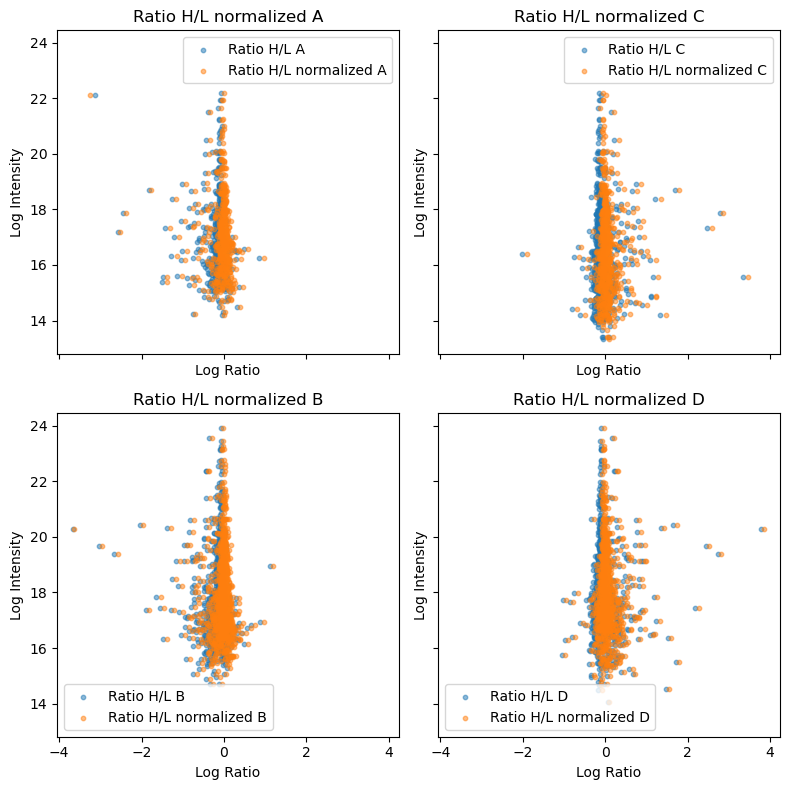

In [14]:
fig, ax = plt.subplots(nrows=2,ncols=2, sharex='all', sharey='all', figsize=(8,8))

for idx, col in enumerate(protRatios.to_list() + normRatios.to_list()):
    # the column number goes from 0 to 3
    c = (idx - 4*(idx//4)) // 2
    # the row number goes from 0 to 1
    r = idx - (idx // 2)*2
    this_ax = ax[r][c]
    # normalised values are plotted on top of the non-nomrmalised values for comparison
    this_ax.scatter(np.log(pg[col]),
                    np.log(pg[intensities[idx]]),
                    label=col,
                    alpha=0.5,
                    s=10)

    this_ax.set_xlabel('Log Ratio')
    this_ax.set_ylabel('Log Intensity')
    this_ax.set_title(col)
    # add a legend for colour scheme
    this_ax.legend()
plt.tight_layout()


Here we remove all rows (i.e. proteins) that are present in less than three of four replicates. Note that the argument groups can also be called with lists of columns. Then the required number of valid values most be true for every list.
MQ generally return H/L ratios, however, we are interested in ratio of Ctrl vs. Tet treatment for all experiments including the label-switches A and B.
So next these ratios are inverted for the experiments A and B using the invert argument of the logarithm function in autoprot.

1663 rows before filter operation.
835 rows after filter operation.


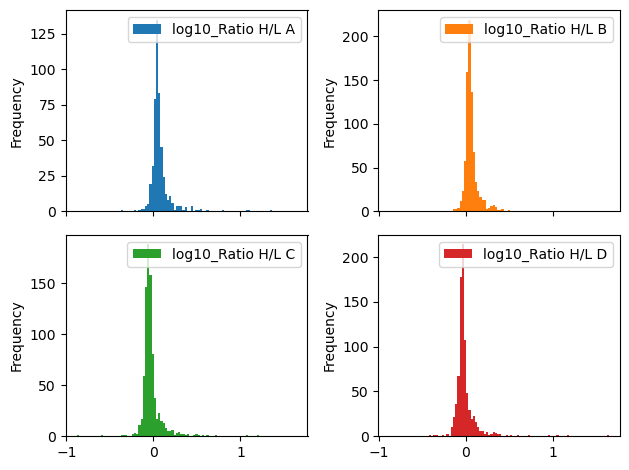

In [15]:
# filter proteins with at least 3 valid ratios
pg = pp.filter_vv(pg, groups=[protRatios.to_list()], n=3)

# invert the first two experiments (i.e. label switches)
invert = [-1,-1,1,1]

# calculate log value of ratios
pg = pp.log(pg, protRatios, base=10, invert=invert)

# plot the log ratios
protRatio_log = pg.filter(regex="^log10_Ratio H\/L [A,B,C,D]+$").columns
hist = pg[protRatio_log].plot(kind='hist',
                              bins=100,
                              subplots=True,
                              layout=(2,2),
                              sharex=True)
plt.tight_layout()

## Data Analysis
The actual data analysis part for the volcano plot is relatively short as only p-values corresponding to the pairwise comparison of groups (i.e. replicates) of ratios between treated and untreated cells need to be calculated. Here, also include a linear model as implemented in the R package limma to demonstrate autoprot's interaction with R.

In [16]:
reps = ['log10_Ratio H/L A', 'log10_Ratio H/L B','log10_Ratio H/L C', 'log10_Ratio H/L D']
# perform standard ttest
pg = ana.ttest(df=pg, reps=reps, cond="_TetvsCtrl_tt", adjust_p_vals=True, alternative='greater')
# perform LIMMA
pg = ana.limma(df=pg, reps=reps, cond="_TetvsCtrl")

Performing one-sample t-Test
LIMMA: Assuming a one sample test


## Data Visualization
For visualisation we use autoprot's volcano function that requires column names for the log fold-change and the corresponding p-values calculated in the previous step.
Thresholds correspond to the dashed lines in the plot and define the default colouring of the data points. An additional annotate_colname is used for labelling the data points, however, here we chose to label only the bait protein.

- The p value from the t-test is plotted against the mean ratio (i.e Tet vs Ctrl)
- Values are highlighted at levels corresponding to an alpha value of 0.05 and an enrichment of at least twofold

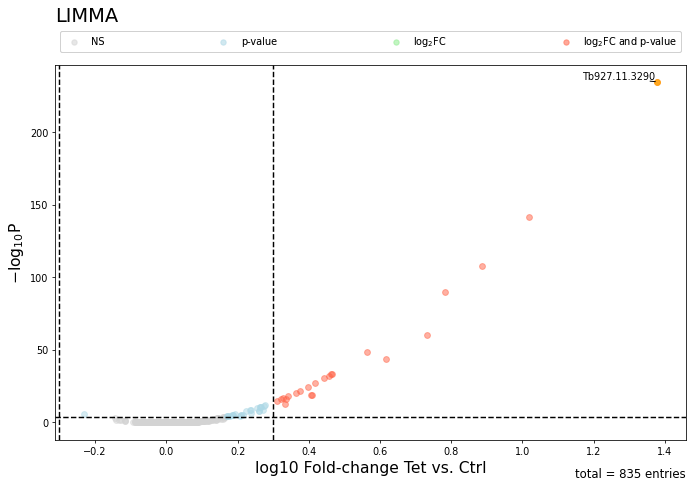

In [17]:
pg['annotProtName'] = pg['Majority protein IDs'].str.split(':').str[0]

#### Plot LIMMA ####
fig = vis.volcano(df=pg,
                  log_fc_colname='logFC_TetvsCtrl',
                  p_colname='adj.P.Val_TetvsCtrl',
                  log_fc_thresh=np.log10(2),
                  p_thresh=10e-5,
                  annotate_colname='annotProtName',
                  annotate='highlight',
                  highlight=pg[pg['Protein IDs'].str.contains('Tb927.11.3290')].index,
                  title= 'LIMMA',
                  ret_fig=True)

fig.set_size_inches((10,7))
fig.set_dpi(70)
# get axis from figure (returns a one-element list)
ax = fig.get_axes()[0]
ax.set_xlabel('log10 Fold-change Tet vs. Ctrl')
plt.tight_layout()

The volcano plot function automatically places the labels according to a density filter and with sufficient distance (similar to the EnhancedVolcano function in R: https://bioconductor.org/packages/release/bioc/vignettes/EnhancedVolcano/inst/doc/EnhancedVolcano.html. Here we use it to label all proteins above the p-value and fold-change thresholds.

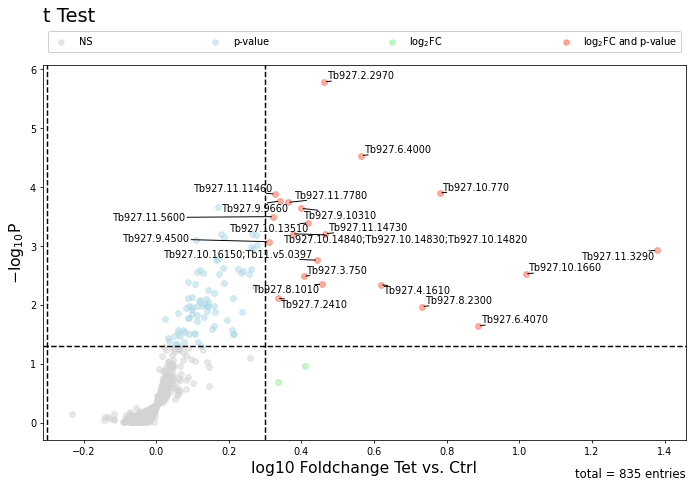

In [18]:
#### Plot ttest ####
fig = vis.volcano(df=pg,
            log_fc_colname='logFC_TetvsCtrl',
            p_colname='pValue_TetvsCtrl_tt',
            log_fc_thresh=np.log10(2),
            p_thresh=0.05,
            annotate_colname='annotProtName',
            annotate='p-value and log2FC',
            title= 't Test',
            ret_fig=True)

fig.set_size_inches((10,7))
fig.set_dpi(70)
ax = fig.get_axes()[0]
ax.set_xlabel('log10 Foldchange Tet vs. Ctrl')
plt.tight_layout()

Autoprot also enables generating interactive plots with the Plotly javascript library. For this, most arguments stay the same as in the previous version but the function name is preceded with an "i". Note that the annotate keyword is not accepted as the interactive version does not requre static annotation but shows data point information for every point on hovering.

In [19]:
import plotly.io as pio

fig = vis.ivolcano(df=pg,
            log_fc_colname='logFC_TetvsCtrl',
            p_colname='adj.P.Val_TetvsCtrl',
            log_fc_thresh=np.log10(2),
            p_thresh=10e-5,
            annotate_colname='annotProtName',
            #annotate='highlight',
            highlight=pg[pg['Protein IDs'].str.contains('Tb927.11.3290')].index,
            title= 'LIMMA',
            #ax=ax
            ret_fig=True
            )

# having the figure update you can change the figure layout any time after plotting
fig.update_layout(pio.templates['simple_white']['layout'])